# Preparation

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd

In [2]:
df = pd.read_csv('car_sales_data.csv')
df.head()

,Manufacturer,Model,Engine size,Fuel type,Year of manufacture,Mileage,Price
0,Ford,Fiesta,1.0,Petrol,2002,127300,3074
1,Porsche,718 Cayman,4.0,Petrol,2016,57850,49704
2,Ford,Mondeo,1.6,Diesel,2014,39190,24072
3,Toyota,RAV4,1.8,Hybrid,1988,210814,1705
4,VW,Polo,1.0,Petrol,2006,127869,4101


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Manufacturer         50000 non-null  object 
 1   Model                50000 non-null  object 
 2   Engine size          50000 non-null  float64
 3   Fuel type            50000 non-null  object 
 4   Year of manufacture  50000 non-null  int64  
 5   Mileage              50000 non-null  int64  
 6   Price                50000 non-null  int64  
dtypes: float64(1), int64(3), object(3)
memory usage: 2.7+ MB


In [4]:
df.isna().sum()

Manufacturer           0
Model                  0
Engine size            0
Fuel type              0
Year of manufacture    0
Mileage                0
Price                  0
dtype: int64

In [7]:
df.duplicated().sum()

np.int64(12)

In [11]:
df.drop_duplicates(inplace=True)

# Feature analysis

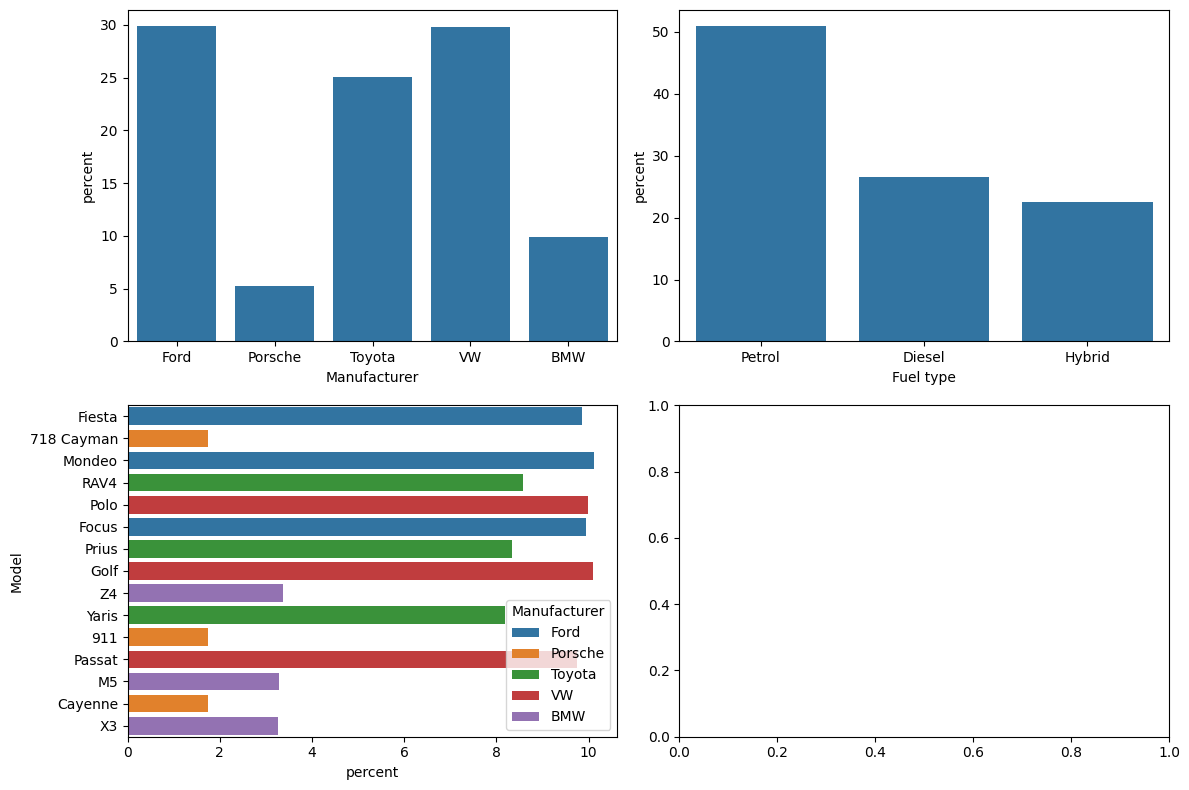

In [12]:
fig, axes = plt.subplots(2, 2, figsize = (12, 8))

sns.countplot(data=df, x='Manufacturer', stat='percent', ax=axes[0,0])
sns.countplot(data=df, x='Fuel type', stat='percent', ax=axes[0,1])
sns.countplot(data=df, y='Model', hue='Manufacturer', stat='percent', ax=axes[1,0])
plt.tight_layout()
plt.show()

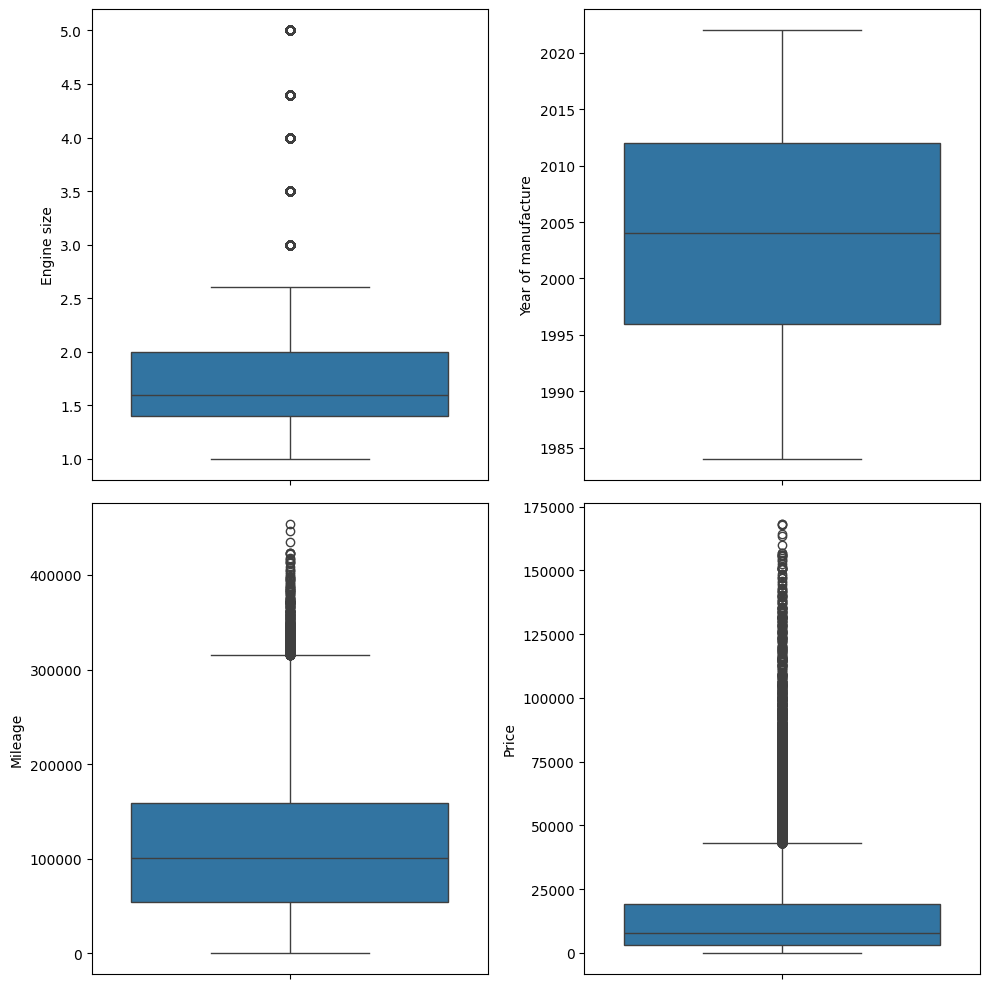

In [13]:
fig, axes = plt.subplots(2, 2, figsize = (10, 10))

sns.boxplot(data=df, y='Engine size', ax=axes[0,0])
sns.boxplot(data=df, y='Year of manufacture', ax=axes[0,1])
sns.boxplot(data=df, y='Mileage', ax=axes[1,0])
sns.boxplot(data=df, y='Price', ax=axes[1,1])
plt.tight_layout()
plt.show()

In [14]:
print(f"Engine outliers: {df[df['Engine size'] >= 3.0].shape[0]}")
print(f"Mileage outliers: {df[df['Mileage'] > 300000].shape[0]}")
print(f"Price outliers: {df[df['Price'] >= 50000].shape[0]}")

Engine outliers: 3951
Mileage outliers: 608
Price outliers: 1739


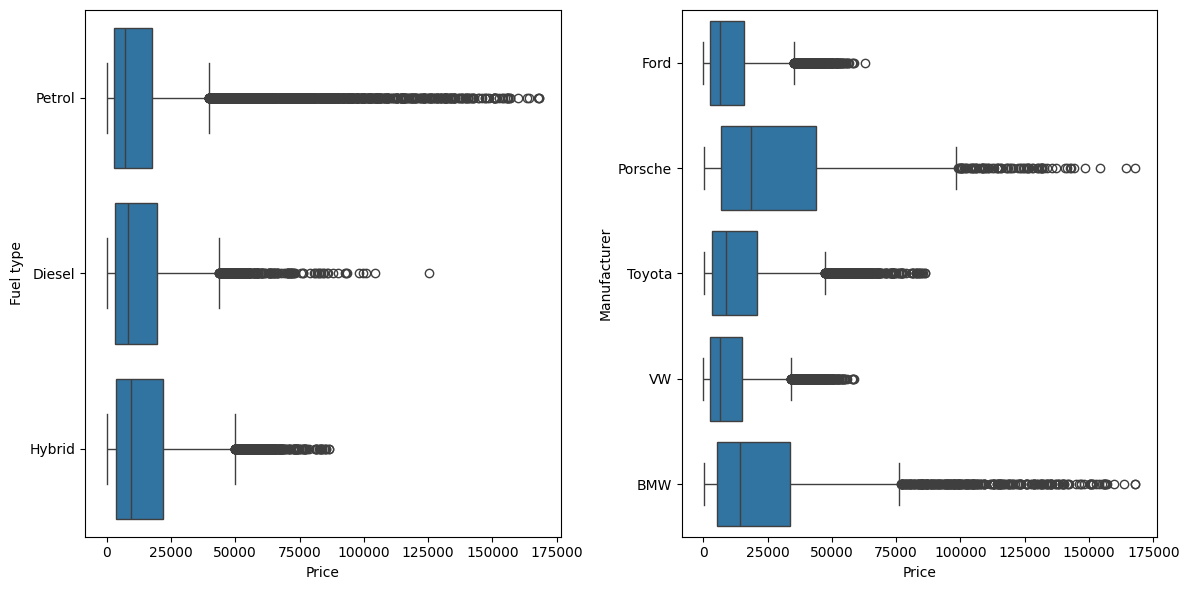

In [15]:
fig, axes = plt.subplots(1, 2, figsize = (12, 6))
sns.boxplot(data=df, x='Price', y='Fuel type', ax=axes[0])
sns.boxplot(data=df, x='Price', y='Manufacturer', ax=axes[1])
plt.tight_layout()
plt.show()

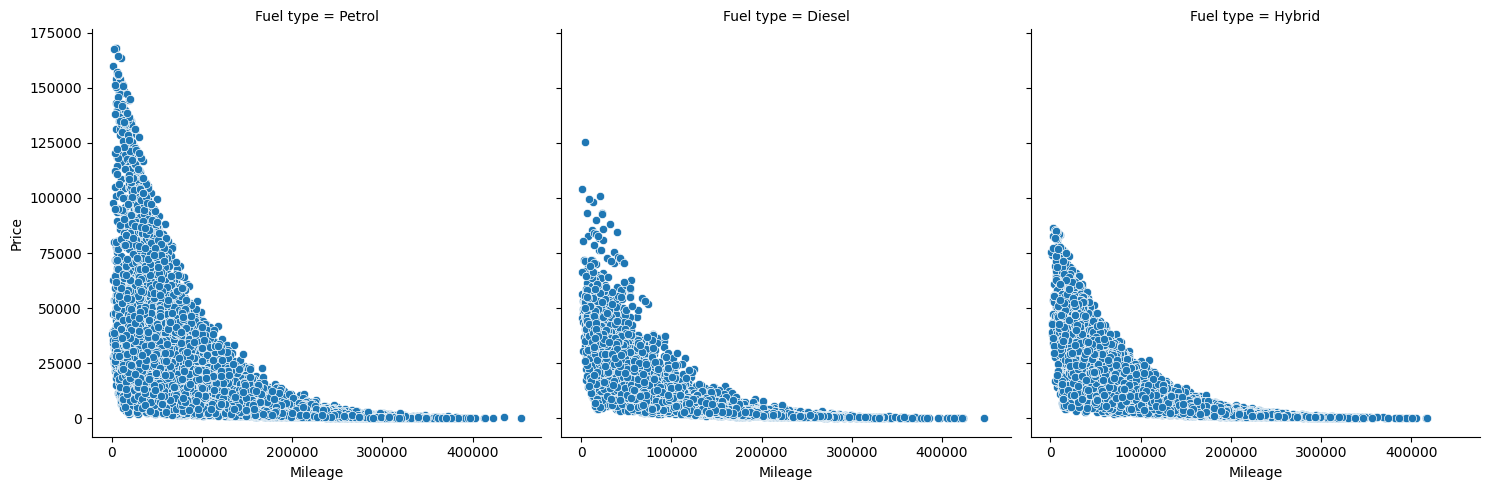

In [16]:
sns.relplot(data=df, x='Mileage', y='Price', col='Fuel type')

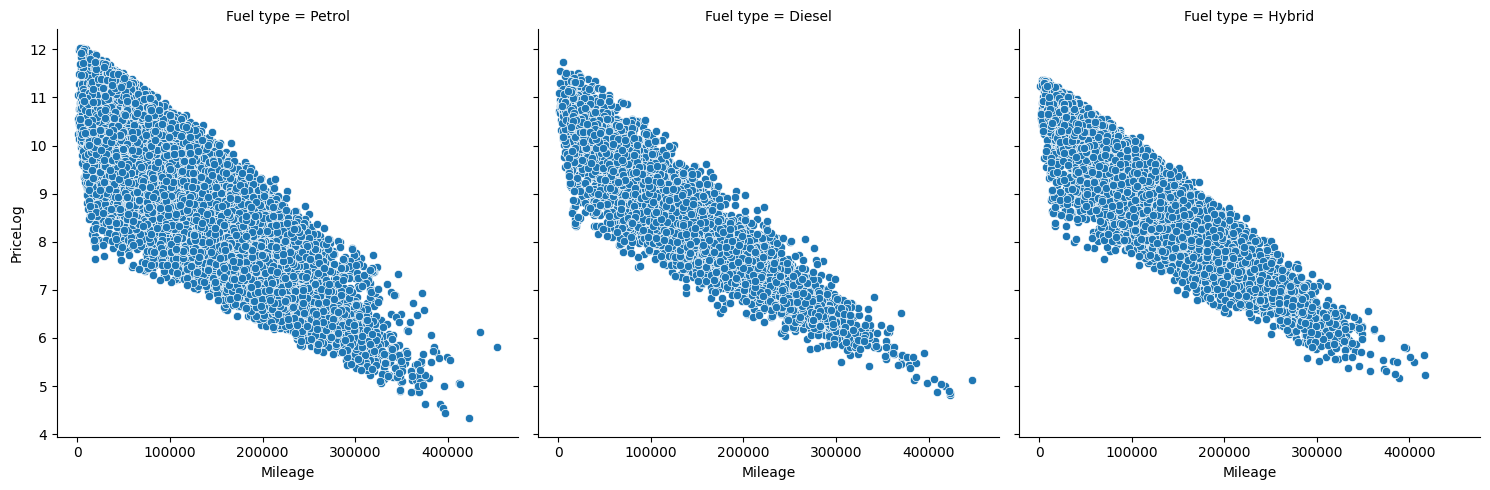

In [17]:
df['PriceLog'] = np.log(df['Price'])
sns.relplot(data=df, x='Mileage', y='PriceLog', col='Fuel type')

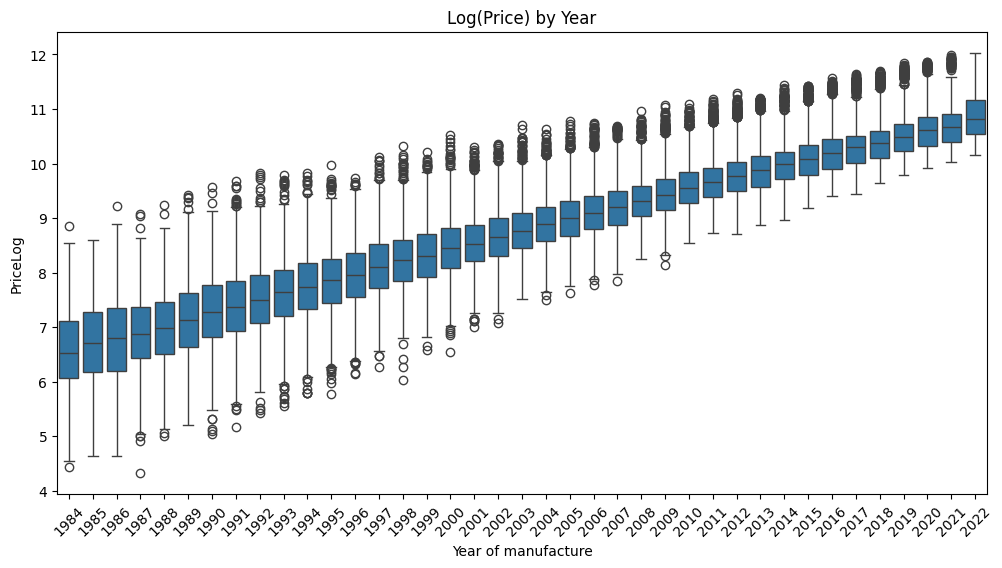

In [18]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='Year of manufacture', y='PriceLog')
plt.xticks(rotation=45)
plt.title('Log(Price) by Year')
plt.show()

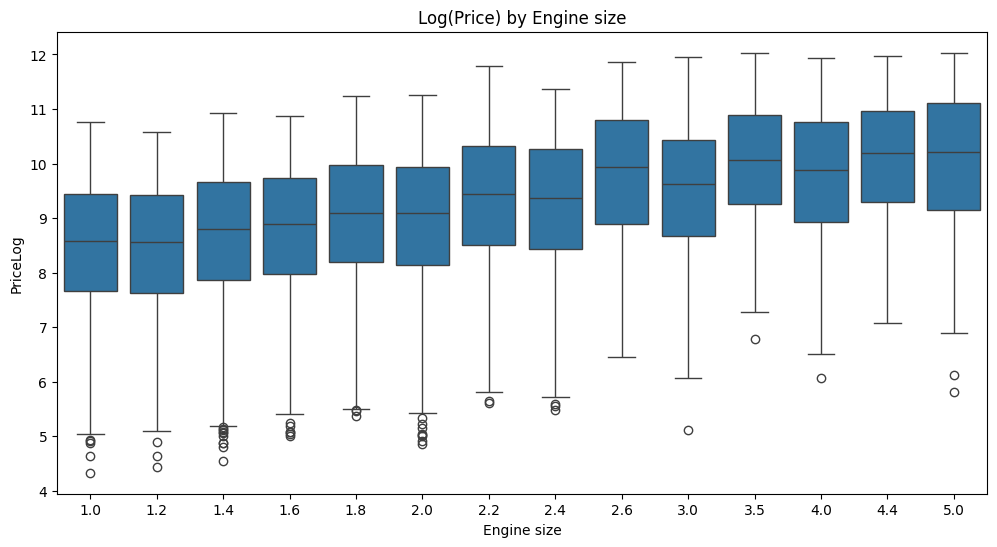

In [19]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='Engine size', y='PriceLog')
plt.title('Log(Price) by Engine size')
plt.show()

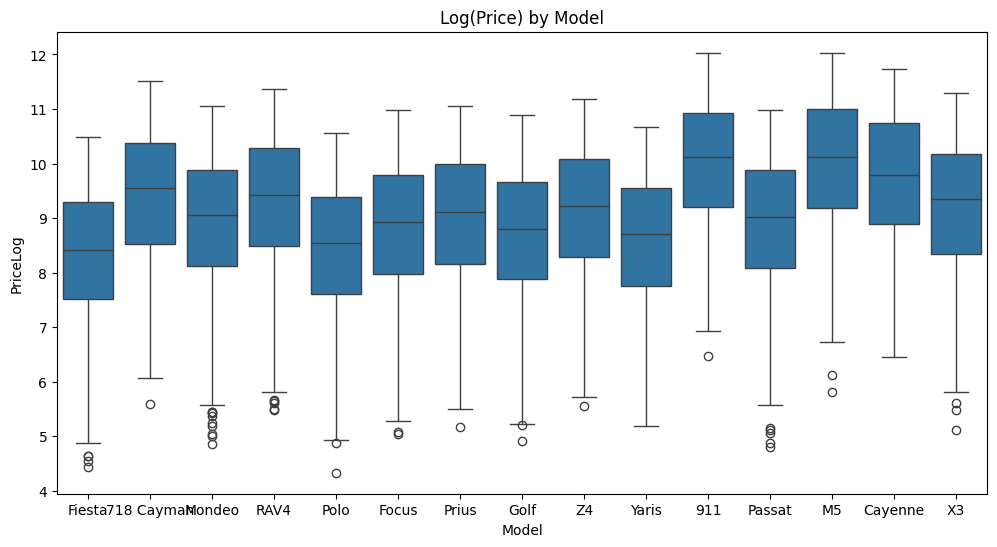

In [20]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='Model', y='PriceLog')
plt.title('Log(Price) by Model')
plt.show()

We will predict log(Price) and then transform the price back.

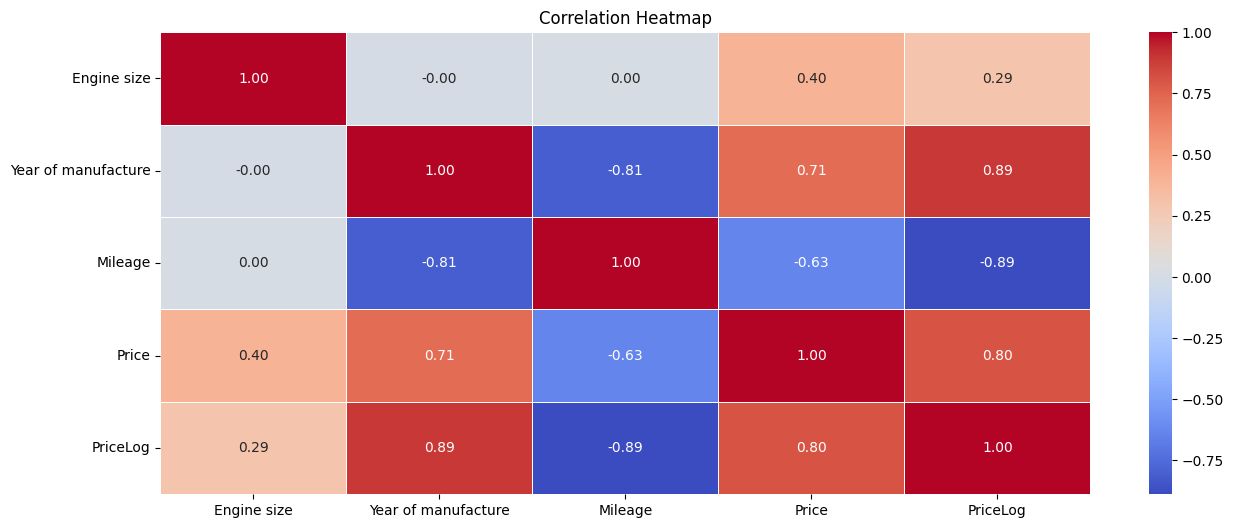

In [21]:
plt.figure(figsize=(15,6))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap="coolwarm", fmt=".2f", linewidths=.5)
plt.title("Correlation Heatmap")
plt.show()

# Ordinary Least Squares

In [22]:
X = df.drop(['Price', 'PriceLog'], axis=1)
y = df['PriceLog']

In [23]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, OneHotEncoder

categorical_features = ['Fuel type', 'Model'] # drop 'Manufacturer'
preprocessor = ColumnTransformer(
    transformers=[
        ('mileage', RobustScaler(), ['Mileage']),
        ('year', StandardScaler(), ['Year of manufacture']),
        ('engine', RobustScaler(), ['Engine size']),
        ('cat', OneHotEncoder(sparse_output=False, drop='first'), categorical_features)
    ], verbose_feature_names_out=False)
preprocessor.set_output(transform='pandas')

,transformers,"[('mileage', ...), ('year', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,False
,force_int_remainder_cols,'deprecated'
,with_centering,True
,with_scaling,True
,quantile_range,"(25.0, ...)"


In [24]:
import sklearn.metrics as skm
import statsmodels.api as sm
from sklearn.model_selection import train_test_split

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [26]:
X_df = preprocessor.fit_transform(X_train)
X_df = sm.add_constant(X_df)

model = sm.OLS(y_train, X_df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               PriceLog   R-squared:                       0.998
Model:                            OLS   Adj. R-squared:                  0.998
Method:                 Least Squares   F-statistic:                 1.100e+06
Date:                Tue, 09 Dec 2025   Prob (F-statistic):               0.00
Time:                        19:58:43   Log-Likelihood:                 60714.
No. Observations:               39990   AIC:                        -1.214e+05
Df Residuals:                   39970   BIC:                        -1.212e+05
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   9.2166      0.002   3848.610      0.000       9.212       9.221
Mileage                -0.8462      0.001  -1292.111      0.000      -0.848      -0.845
Year of manufacture     0.6151      0.000   1365.241      0.000       0.614       0.616
Engine size             0.1623      0.001    318.624      0.000       0.161       0.163
Fuel type_Hybrid        0.1336      0.001    105.890      0.000       0.131       0.136
Fuel type_Petrol       -0.0489      0.001    -56.975      0.000      -0.051      -0.047
Model_911               0.5810      0.003    205.731      0.000       0.575       0.586
Model_Cayenne           0.1339      0.003     46.761      0.000       0.128       0.140
Model_Fiesta           -0.6334      0.003   -248.270      0.000      -0.638      -0.628
Model_Focus            -0.2376      0.002    -98.251      0.000      -0.242      -0.233
Model_Golf             -0.4039      0.002   -167.922      0.000      -0.409      -0.399
Model_M5                0.2038      0.003     71.763      0.000       0.198       0.209
Model_Mondeo           -0.2320      0.002    -94.432      0.000      -0.237      -0.227
Model_Passat           -0.1760      0.002    -71.765      0.000      -0.181      -0.171
Model_Polo             -0.5897      0.002   -240.856      0.000      -0.594      -0.585
Model_Prius            -0.2128      0.003    -78.295      0.000      -0.218      -0.207
Model_RAV4             -0.0248      0.002    -10.201      0.000      -0.030      -0.020
Model_X3               -0.1003      0.003    -38.858      0.000      -0.105      -0.095
Model_Yaris            -0.4857      0.003   -184.188      0.000      -0.491      -0.481
Model_Z4               -0.1400      0.002    -56.268      0.000      -0.145      -0.135
==============================================================================
Omnibus:                     5780.889   Durbin-Watson:                   2.013
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            10635.786
Skew:                          -0.930   Prob(JB):                         0.00
Kurtosis:                       4.711   Cond. No.                         43.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [27]:
summary = model.summary2().tables[1]
summary_df = summary.reset_index().rename(columns={'index': 'feature'})

if 'const' in summary_df['feature'].values:
    summary_df = summary_df[summary_df['feature'] != 'const']

summary_df['abs_coef'] = np.abs(summary_df['Coef.'])
count = 10;
top_by_coef = summary_df.sort_values('abs_coef', ascending=False).head(count)

print(f"Top {count} Features by Coefficient:")
print(top_by_coef[['feature', 'Coef.', 'P>|t|']])

Top 10 Features by Coefficient:
                feature     Coef.  P>|t|
1               Mileage -0.846245    0.0
8          Model_Fiesta -0.633351    0.0
2   Year of manufacture  0.615137    0.0
14           Model_Polo -0.589654    0.0
6             Model_911  0.580965    0.0
18          Model_Yaris -0.485746    0.0
10           Model_Golf -0.403858    0.0
9           Model_Focus -0.237561    0.0
12         Model_Mondeo -0.232031    0.0
15          Model_Prius -0.212764    0.0


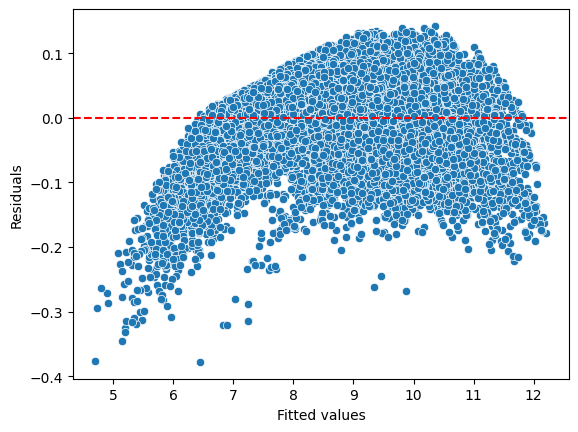

In [28]:
sns.scatterplot(x=model.fittedvalues, y=model.resid)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Fitted values")
plt.ylabel("Residuals")
plt.show()

In [29]:
X_test_df = preprocessor.transform(X_test)
X_test_df = sm.add_constant(X_test_df)
y_pred_log = model.predict(X_test_df)

In [30]:
y_pred_price = np.exp(y_pred_log)
y_true_price = np.exp(y_test)

In [31]:
mse = skm.mean_squared_error(y_true_price, y_pred_price)
rmse = np.sqrt(mse)
mae = skm.mean_absolute_error(y_true_price, y_pred_price)
r2 = skm.r2_score(y_true_price, y_pred_price)
print(f"MSE={mse:.2f}, RMSE={rmse:.2f}, MAE={mae:.2f}, R^2={r2:.2f}")

MSE=2494718.89, RMSE=1579.47, MAE=650.94, R^2=0.99


# Decision Tree Regression

In [32]:
X = df.drop(['Price', 'PriceLog'], axis=1)
y = df['Price']

In [33]:
categorical_features = ['Fuel type', 'Model', 'Manufacturer']
X = pd.get_dummies(data=X, columns=categorical_features, drop_first=False)
X.head()

,Engine size,Year of manufacture,Mileage,Fuel type_Diesel,Fuel type_Hybrid,Fuel type_Petrol,Model_718 Cayman,Model_911,Model_Cayenne,Model_Fiesta,...,Model_Prius,Model_RAV4,Model_X3,Model_Yaris,Model_Z4,Manufacturer_BMW,Manufacturer_Ford,Manufacturer_Porsche,Manufacturer_Toyota,Manufacturer_VW
0,1.0,2002,127300,False,False,True,False,False,False,True,...,False,False,False,False,False,False,True,False,False,False
1,4.0,2016,57850,False,False,True,True,False,False,False,...,False,False,False,False,False,False,False,True,False,False
2,1.6,2014,39190,True,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
3,1.8,1988,210814,False,True,False,False,False,False,False,...,False,True,False,False,False,False,False,False,True,False
4,1.0,2006,127869,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True


In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [46]:
from sklearn.tree import DecisionTreeRegressor

model_tree = DecisionTreeRegressor(max_depth=None, min_samples_leaf=8, random_state=42)
model_tree.fit(X_train, y_train)
y_pred = model_tree.predict(X_test)

In [47]:
mse = skm.mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = skm.mean_absolute_error(y_test, y_pred)
r2 = skm.r2_score(y_test, y_pred)
print(f"MSE={mse:.2f}, RMSE={rmse:.2f}, MAE={mae:.2f}, R^2={r2:.2f}")

MSE=2513992.96, RMSE=1585.56, MAE=818.55, R^2=0.99


In [48]:
print(f"Decision tree depth: {model_tree.get_depth()}")
print(f"Decision tree leaves: {model_tree.get_n_leaves()}")

Decision tree depth: 20
Decision tree leaves: 3872


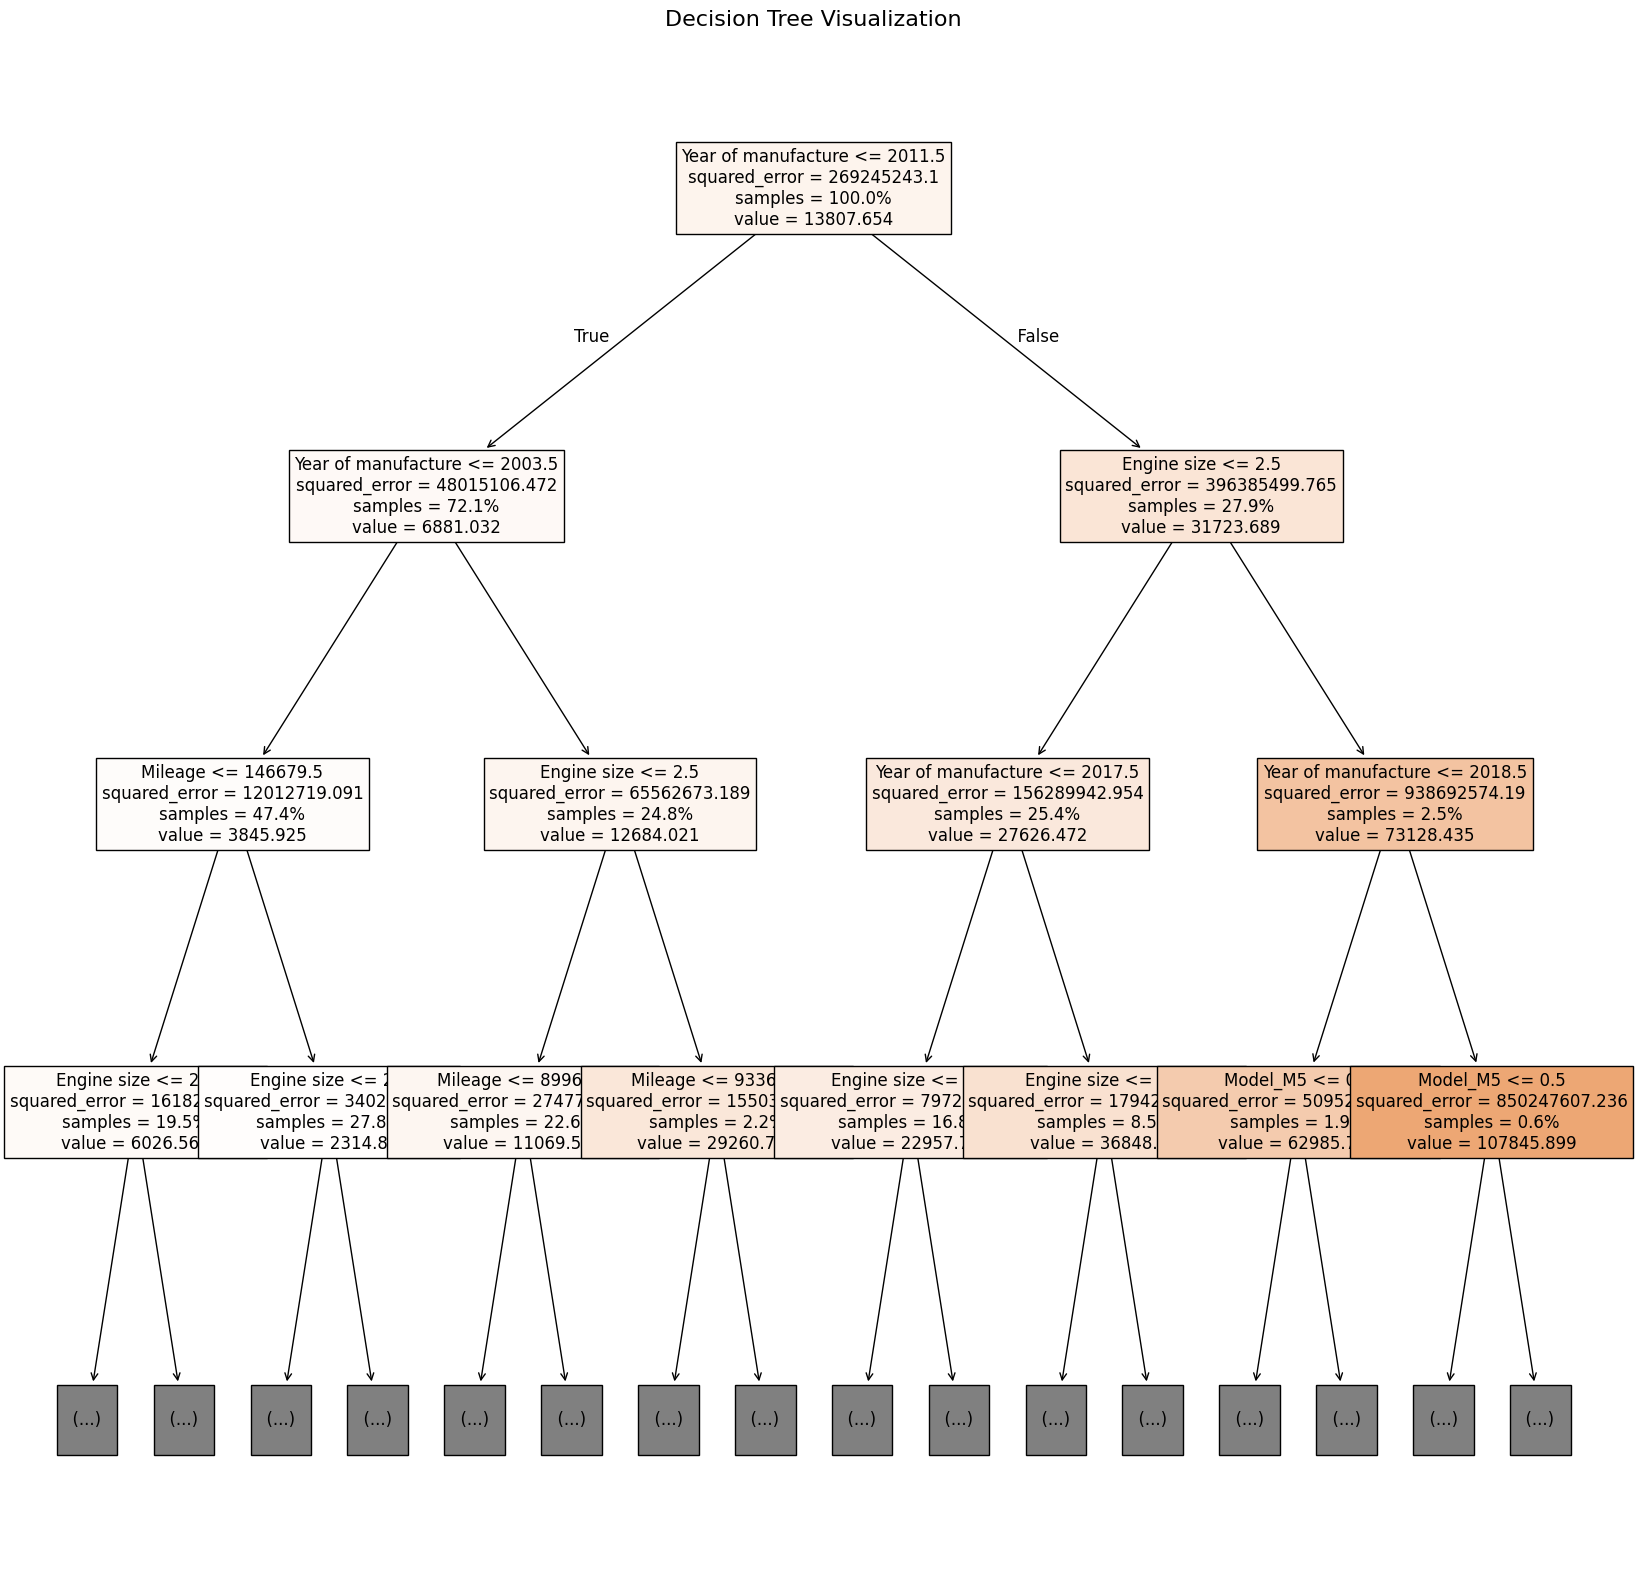

In [49]:
from sklearn.tree import plot_tree

plt.figure(figsize=(20, 20))
plot_tree(model_tree, 
          max_depth=3,
          feature_names=X_train.columns, 
          filled=True,                           
          fontsize=12,
          proportion=True)
plt.title("Decision Tree Visualization", fontsize=16)
plt.show()